<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/X-CLIP/Zero_shot_classify_a_YouTube_video_with_X_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

We first install 🤗 Transformers, decord and pytube.

In [39]:
!pip install -q git+https://github.com/huggingface/transformers.git decord

In [40]:
!pip install -q pytube

## Load video

Here you can provide any YouTube video you like! Just provide the URL :) in my case, I'm providing a YouTube video of Karpathy teaching neural networks.

In [41]:
from pytube import YouTube

youtube_url = 'https://www.youtube.com/watch?v=zjzjnnBwZ9c'
yt = YouTube(youtube_url)

streams = yt.streams.filter(file_extension='mp4')
print(streams)

[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">, <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">, <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e" progressive="False" type="video">, <Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d4015" progressive="False" type="video">, <Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400c" progressive="False" type="video">, <Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">, <Stream: 

In [42]:
len(streams)

9

In [43]:
file_path = streams[0].download()

## Sample frames

The X-CLIP model we'll use expects 32 frames for a given video. Let's sample them:

In [44]:
from decord import VideoReader, cpu
import torch
import numpy as np

from huggingface_hub import hf_hub_download

np.random.seed(0)

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 32 frames
videoreader.seek(0)
indices = sample_frame_indices(clip_len=32, frame_sample_rate=4, seg_len=len(videoreader))
video = videoreader.get_batch(indices).asnumpy()

In [45]:
video.shape

(32, 360, 640, 3)

Let's visualize the first of the 32 frames!

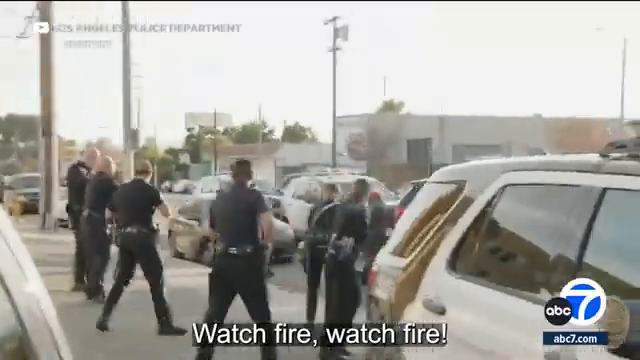

In [46]:
from PIL import Image

Image.fromarray(video[19])

## Load X-CLIP model

Let's instantiate the XCLIP model, along with its processor.

In [47]:
from transformers import XCLIPProcessor, XCLIPModel

model_name = "microsoft/xclip-base-patch16-zero-shot"
processor = XCLIPProcessor.from_pretrained(model_name)
model = XCLIPModel.from_pretrained(model_name)

## Zero-shot classification

Usage of X-CLIP is identical to CLIP: you can feed it a bunch of texts, and the model determines which ones go best with the video.

In [48]:
import torch

inputs = processor(text=["going shopping", "traffic lights", "roofs"], videos=list(video), return_tensors="pt", padding=True)

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

probs = outputs.logits_per_video.softmax(dim=1)
probs

Unused or unrecognized kwargs: padding.


tensor([[0.1979, 0.7977, 0.0043]])